# Machine Learning: Predicting Property Quality and Price


In [4]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
%%capture
!apt update
!pip install kaggle

# **Part I:** Preprocessing and Modeling in `scikit-learn`

## **1.1** Data Loading and Preprocessing

### **1.1.1** Read and Load Data

We are using one CSV, `properties_data.csv` from a Kaggle [dataset](https://www.kaggle.com/datasets/dataregress/dubai-properties-dataset/data). The dataset contains 38 columns and over 1900 property entries.



In [6]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!mkdir ~/.kaggle

In [8]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [9]:
!!kaggle datasets download -d dataregress/dubai-properties-dataset

['Downloading dubai-properties-dataset.zip to /content',
 '',
 '  0% 0.00/60.0k [00:00<?, ?B/s]',
 '',
 '100% 60.0k/60.0k [00:00<00:00, 9.26MB/s]']

In [10]:
!unzip /content/dubai-properties-dataset.zip

Archive:  /content/dubai-properties-dataset.zip
  inflating: properties_data.csv     


In [11]:
df_properties = pd.read_csv('properties_data.csv')

df_properties.head()

,id,neighborhood,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,...,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet
0,5528049,Palm Jumeirah,25.113208,55.138932,2700000,1079,2502.32,1,2,Medium,...,False,False,True,False,False,False,False,False,True,False
1,6008529,Palm Jumeirah,25.106809,55.151201,2850000,1582,1801.52,2,2,Medium,...,False,False,True,True,False,False,False,False,True,False
2,6034542,Jumeirah Lake Towers,25.063302,55.137728,1150000,1951,589.44,3,5,Medium,...,False,True,True,True,False,False,False,True,True,True
3,6326063,Culture Village,25.227295,55.341761,2850000,2020,1410.89,2,3,Low,...,False,False,False,False,False,False,False,False,False,False
4,6356778,Palm Jumeirah,25.114275,55.139764,1729200,507,3410.65,0,1,Medium,...,False,True,True,True,True,False,False,True,True,False


### **1.1.2** Understanding Data



In [12]:
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905 entries, 0 to 1904
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1905 non-null   int64  
 1   neighborhood         1905 non-null   object 
 2   latitude             1905 non-null   float64
 3   longitude            1905 non-null   float64
 4   price                1905 non-null   int64  
 5   size_in_sqft         1905 non-null   int64  
 6   price_per_sqft       1905 non-null   float64
 7   no_of_bedrooms       1905 non-null   int64  
 8   no_of_bathrooms      1905 non-null   int64  
 9   quality              1905 non-null   object 
 10  maid_room            1905 non-null   bool   
 11  unfurnished          1905 non-null   bool   
 12  balcony              1905 non-null   bool   
 13  barbecue_area        1905 non-null   bool   
 14  built_in_wardrobes   1905 non-null   bool   
 15  central_ac           1905 non-null   b

In [13]:
df_properties.describe()

,id,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms
count,1.905000e+03,1905.000000,1905.000000,1.905000e+03,1905.000000,1905.000000,1905.000000,1905.000000
mean,7.573308e+06,25.116538,55.212338,2.085830e+06,1417.050394,1327.243785,1.793176,2.512861
std,1.925252e+05,0.062647,0.068794,2.913200e+06,891.487639,668.473559,0.949489,1.063117
min,5.528049e+06,24.865992,55.069311,2.200000e+05,294.000000,361.870000,0.000000,1.000000
25%,7.560167e+06,25.072791,55.145389,8.900000e+05,840.000000,870.920000,1.000000,2.000000
50%,7.631829e+06,25.096700,55.207506,1.400000e+06,1271.000000,1169.590000,2.000000,2.000000
75%,7.670328e+06,25.188130,55.271797,2.200000e+06,1703.000000,1622.500000,2.000000,3.000000
max,7.706643e+06,25.273623,55.441623,3.500000e+07,9576.000000,4805.870000,5.000000,6.000000


## **1.2** EDA



### **1.2.1** Visualization

#### (a) Examining Neighborhood and Quality

For the ***top ten neighborhoods with the most properties***, we want to find the number of Low, Medium, High, Ultra listings from the `quality` column.



In [14]:
top_ten_neighborhoods = df_properties[['id', 'neighborhood']].groupby('neighborhood').count().sort_values(by = 'id', ascending = False).head(10).reset_index();
top_ten_neighborhoods

,neighborhood,id
0,Downtown Dubai,302
1,Dubai Marina,288
2,Jumeirah Village Circle,200
3,Palm Jumeirah,178
4,Jumeirah Beach Residence,116
5,Business Bay,97
6,Jumeirah Lake Towers,70
7,Dubai Hills Estate,53
8,The Views,47
9,Jumeirah,39


In [15]:
ten_neighborhoods_df = top_ten_neighborhoods[['neighborhood']].merge(df_properties, on = 'neighborhood')
ten_neighborhoods_df

,neighborhood,id,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,...,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet
0,Downtown Dubai,6406935,25.194935,55.282665,2690000,1521,1768.57,2,3,Medium,...,False,False,True,True,False,False,False,False,True,False
1,Downtown Dubai,6473651,25.198796,55.271342,3550000,1918,1850.89,3,4,Low,...,False,False,False,True,False,False,False,False,True,False
2,Downtown Dubai,6530645,25.198316,55.270758,2700000,1348,2002.97,2,3,Medium,...,False,False,False,False,False,False,False,False,True,False
3,Downtown Dubai,6562472,25.197020,55.271023,1490000,1167,1276.78,2,2,Medium,...,False,False,True,True,False,False,False,False,False,False
4,Downtown Dubai,6728311,25.197316,55.274196,3999900,2323,1721.87,3,4,Medium,...,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,Jumeirah,7692445,25.240419,55.252770,2270000,1216,1866.78,2,3,Medium,...,False,False,True,True,False,False,False,False,False,True
1386,Jumeirah,7695774,25.240419,55.252770,1366000,816,1674.02,1,1,Medium,...,False,False,True,True,False,False,False,False,True,False
1387,Jumeirah,7695790,25.215192,55.235827,4905000,1574,3116.26,1,1,Medium,...,False,False,True,True,False,False,False,False,True,False
1388,Jumeirah,7695797,25.215192,55.235827,9209000,2249,4094.71,2,2,Medium,...,False,False,True,True,False,False,False,False,True,False


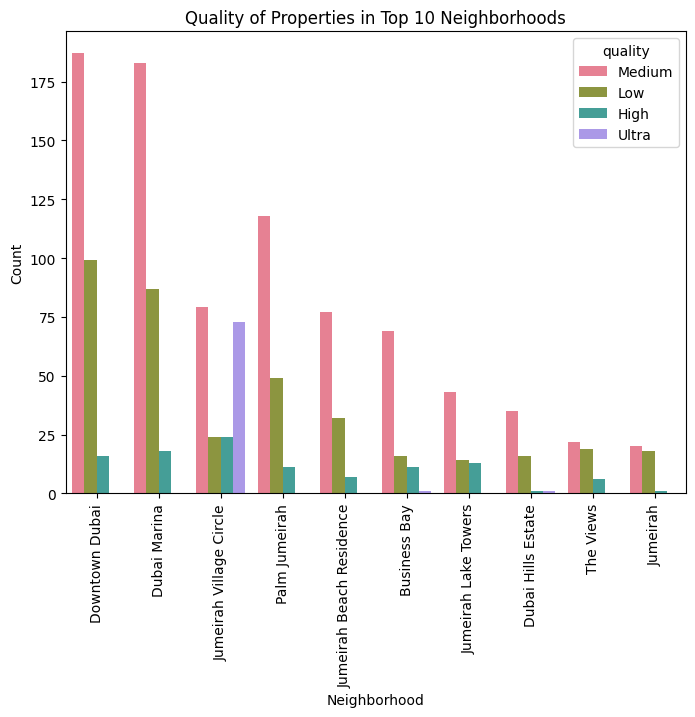

In [16]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'neighborhood', hue = 'quality', data = ten_neighborhoods_df, palette = 'husl')
plt.title('Quality of Properties in Top 10 Neighborhoods')
plt.ylabel('Count')
plt.xlabel('Neighborhood')
plt.xticks(rotation=90)

plt.show()

#### (b) 3D Scatterplot

We want to examine the relationship between three variables: `number_of_bedrooms`, `number_of_bathrooms`, and `price`. We also want to examine `quality` as well.



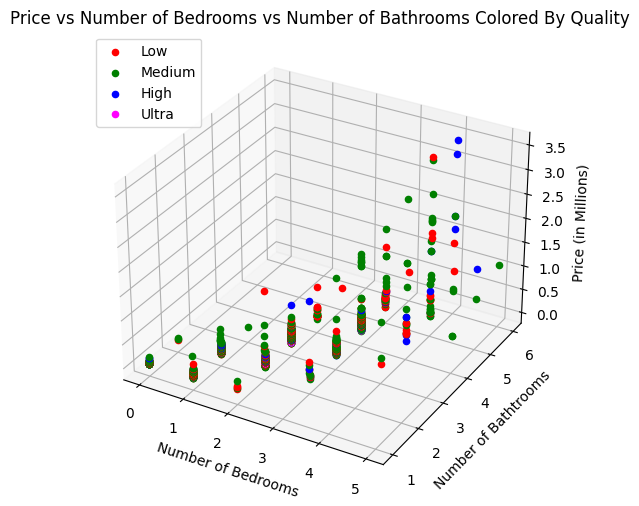

In [86]:
import matplotlib.pyplot as plt

# save the corresponding series from dataframe into lists/containers
number_of_bedrooms = df_properties['no_of_bedrooms'].to_list()
number_of_bathrooms = df_properties['no_of_bathrooms'].to_list()
price = df_properties['price'].to_list()
quality = df_properties['quality'].to_list()

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection = '3d')

color_dict = {'Low' : 'red', 'Medium' : 'green', 'High' : 'blue', 'Ultra' : 'magenta'}

# iterate through and plot datapoints
for x_val, y_val, z_val, cat in zip(number_of_bedrooms, number_of_bathrooms, price, quality):
    ax.scatter(x_val, y_val, z_val, color=color_dict[cat])

ax.set_title('Price vs Number of Bedrooms vs Number of Bathrooms Colored By Quality')
ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Number of Bathtrooms')
ax.set_zlabel('Price (in Millions)')

for quality, color in color_dict.items():
    ax.scatter([], [], [], c=color, marker='o', label=quality)
ax.legend(loc='upper left')
plt.show()

### **1.2.2** Correlation of Feature Variables



_**Isolating Numerics from Categorical Features**_



In [18]:
for col in df_properties.columns:
  print(col, df_properties[col].nunique(), df_properties[col].dtype)

id 1905 int64
neighborhood 54 object
latitude 723 float64
longitude 722 float64
price 821 int64
size_in_sqft 1121 int64
price_per_sqft 1784 float64
no_of_bedrooms 6 int64
no_of_bathrooms 6 int64
quality 4 object
maid_room 2 bool
unfurnished 2 bool
balcony 2 bool
barbecue_area 2 bool
built_in_wardrobes 2 bool
central_ac 2 bool
childrens_play_area 2 bool
childrens_pool 2 bool
concierge 2 bool
covered_parking 2 bool
kitchen_appliances 2 bool
lobby_in_building 2 bool
maid_service 2 bool
networked 2 bool
pets_allowed 2 bool
private_garden 2 bool
private_gym 2 bool
private_jacuzzi 2 bool
private_pool 2 bool
security 2 bool
shared_gym 2 bool
shared_pool 2 bool
shared_spa 2 bool
study 2 bool
vastu_compliant 2 bool
view_of_landmark 2 bool
view_of_water 2 bool
walk_in_closet 2 bool


In [19]:
num_df = df_properties[['size_in_sqft', 'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms']]
cat_df = df_properties.drop(['id', 'latitude', 'longitude', 'quality', 'price', 'size_in_sqft', 'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms'], axis = 1)

In [20]:
sorted_columns = list(num_df.columns)
sorted_columns.sort()
num_df = num_df[sorted_columns]

sorted_columns = list(cat_df.columns)
sorted_columns.sort()
cat_df = cat_df[sorted_columns]

In [21]:
num_df.columns

Index(['no_of_bathrooms', 'no_of_bedrooms', 'price_per_sqft', 'size_in_sqft'], dtype='object')

In [22]:
cat_df.columns

Index(['balcony', 'barbecue_area', 'built_in_wardrobes', 'central_ac',
       'childrens_play_area', 'childrens_pool', 'concierge', 'covered_parking',
       'kitchen_appliances', 'lobby_in_building', 'maid_room', 'maid_service',
       'neighborhood', 'networked', 'pets_allowed', 'private_garden',
       'private_gym', 'private_jacuzzi', 'private_pool', 'security',
       'shared_gym', 'shared_pool', 'shared_spa', 'study', 'unfurnished',
       'vastu_compliant', 'view_of_landmark', 'view_of_water',
       'walk_in_closet'],
      dtype='object')

_**Correlation Heatmap**_



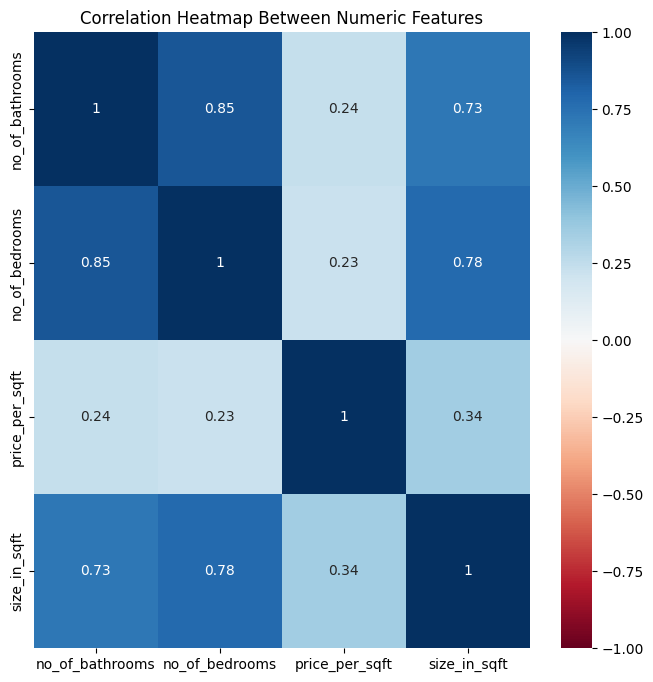

In [23]:
corr_matrix = num_df.corr()
plt.figure(figsize = (8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center = 0, vmin = -1, vmax = 1)
plt.title('Correlation Heatmap Between Numeric Features')
plt.show()



## **1.3** Feature Engineering



### **1.3.1** Cast Boolean Values into Integers

In [24]:
encoded_df_properties = df_properties.drop(['id', 'latitude', 'longitude', 'neighborhood'], axis = 1)

In [25]:
for col in encoded_df_properties:
  if encoded_df_properties[col].dtype == 'bool':
    encoded_df_properties[col] = encoded_df_properties[col].astype(int)

In [26]:
encoded_df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905 entries, 0 to 1904
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                1905 non-null   int64  
 1   size_in_sqft         1905 non-null   int64  
 2   price_per_sqft       1905 non-null   float64
 3   no_of_bedrooms       1905 non-null   int64  
 4   no_of_bathrooms      1905 non-null   int64  
 5   quality              1905 non-null   object 
 6   maid_room            1905 non-null   int64  
 7   unfurnished          1905 non-null   int64  
 8   balcony              1905 non-null   int64  
 9   barbecue_area        1905 non-null   int64  
 10  built_in_wardrobes   1905 non-null   int64  
 11  central_ac           1905 non-null   int64  
 12  childrens_play_area  1905 non-null   int64  
 13  childrens_pool       1905 non-null   int64  
 14  concierge            1905 non-null   int64  
 15  covered_parking      1905 non-null   i

### **1.3.2** Encode Classes in 'Quality' Column

We will be predicting the `quality` for our classification problem. We first want to transform our target into numerical values:
*   Low: 0
*   Medium: 1
*   High: 2
*   Ultra: 3



In [27]:
encoded_df_properties['quality'] = encoded_df_properties['quality'].apply(lambda x : 0 if x == 'Low' else (1 if x == 'Medium' else (2 if x == 'High' else 3)))

In [28]:
encoded_df_properties['quality'].unique()

array([1, 0, 2, 3])

## **1.4** Modeling (sklearn)

### **1.4.1** Preprocessing: Create Features and Label and Split Data into Train and Test



In [29]:
features = encoded_df_properties.drop('quality', axis = 1)

target = encoded_df_properties['quality']

In [30]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = seed)

### **1.4.2** Classification Models

#### (a) Logistic Regression


In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty = None, multi_class = 'multinomial')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

log_acc = model.score(X_test, y_test)

log_acc

0.5931758530183727

#### (b) Random Forest Classifier



In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

model = RandomForestClassifier(class_weight = 'balanced', n_estimators = 120, max_depth = 30, random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rf_acc = model.score(X_test, y_test)

rf_confusion = confusion_matrix(y_test, y_pred)

rf_acc, rf_confusion

(0.9212598425196851,
 array([[ 97,  15,   0,   0],
        [  1, 225,   2,   0],
        [  0,  12,  17,   0],
        [  0,   0,   0,  12]]))

#### (c) PCA to Reduce Dimensionality



_**Initial PCA**_



In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA()
X2 = pca.fit(X_train_scaled)

_**Cumulative Explained Variance Ratios**_



In [34]:
explained_variance_ratios = pca.explained_variance_ratio_

cum_evr = np.cumsum(explained_variance_ratios)

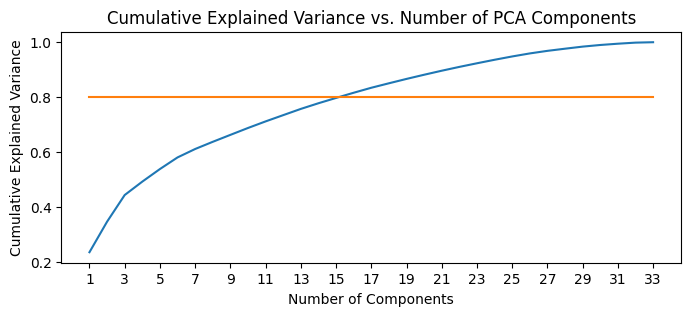

In [35]:
x_ticks = np.arange(len(cum_evr)) + 1

plt.figure(figsize = (8, 3))
plt.plot(x_ticks, cum_evr)
plt.plot(x_ticks, 0.8 * (np.ones(len(cum_evr))))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of PCA Components')
plt.xticks(range(1, len(cum_evr) + 1, 2))
plt.show()

_**Final PCA**_



In [36]:
pca = PCA(n_components = 16)
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.transform(X_test_scaled)

#### (d) Logistic Regression with PCA



In [37]:
log_reg_pca = LogisticRegression(penalty = None, multi_class = 'multinomial')
log_reg_pca.fit(X_train_pca, y_train)

y_pred = log_reg_pca.predict(X_test_pca)

test_accuracy = log_reg_pca.score(X_test_pca, y_test)

test_accuracy

0.9921259842519685

### **1.4.3.0** Regression: Split Data into Train and Test

 We will be predicting `price` for regression models.



In [38]:
reg_df_properties = encoded_df_properties[['price', 'size_in_sqft', 'no_of_bedrooms', 'no_of_bathrooms']]

In [39]:
features = reg_df_properties.drop('price', axis = 1)

target = reg_df_properties['price']

In [40]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = seed)

### **1.4.3.1** Regression Models



#### (a) Linear Regression (Unregularized)



In [48]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

lin_reg_score = reg.score(X_test, y_test)

lin_reg_score

0.7092097276707039

#### (b) Lasso Regression



In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
from sklearn import linear_model

reg_lasso = linear_model.Lasso(alpha = 0.5)
reg_lasso.fit(X_train_scaled, y_train)

y_pred = reg_lasso.predict(X_test_scaled)

lasso_score = reg_lasso.score(X_test_scaled, y_test)

lasso_score

0.7092097454167732

### **1.4.4** K-Means Clustering



#### (a) Find the best number of clusters with the elbow plot

In [44]:
features = encoded_df_properties.drop('quality', axis = 1)

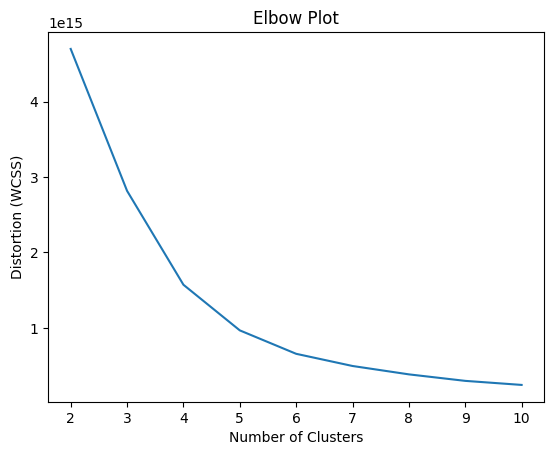

In [45]:

from sklearn.cluster import KMeans

wcss = []
seed = 0
for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 5)
  kmeans.fit(features)
  wcss.append(kmeans.inertia_)

sns.lineplot(x = [2, 3, 4, 5, 6, 7, 8, 9, 10], y = wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion (WCSS)')
plt.title('Elbow Plot')
plt.show()

In [46]:
number_of_clusters = 5

#### (b) Re-fit with the best number of clusters

In [47]:
kmeans = KMeans(n_clusters = number_of_clusters, random_state = seed, n_init = 5)
kmeans.fit(features)

KMeans(n_clusters=5, n_init=5, random_state=0)

# **Part II:** Distributed Machine Learning with Apache Spark



In [49]:
%%capture

!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [50]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('bigdata-hw4').getOrCreate()
sqlContext = SQLContext(spark)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [51]:
%load_ext sparkmagic.magics

In [52]:
# Graph section
import networkx as nx

# SQLite RDBMS
import sqlite3

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## **2.1** Initializing Spark Data



### **2.1.0** Converting the Pandas Dataframe into a Spark Dataframe


In [53]:
properties_sdf = spark.createDataFrame(encoded_df_properties)

In [54]:
from pyspark.sql.functions import col
properties_sdf = properties_sdf.withColumn("quality", col("quality").cast(DoubleType()))
properties_sdf.show()

+-------+------------+--------------+--------------+---------------+-------+---------+-----------+-------+-------------+------------------+----------+-------------------+--------------+---------+---------------+------------------+-----------------+------------+---------+------------+--------------+-----------+---------------+------------+--------+----------+-----------+----------+-----+---------------+----------------+-------------+--------------+
|  price|size_in_sqft|price_per_sqft|no_of_bedrooms|no_of_bathrooms|quality|maid_room|unfurnished|balcony|barbecue_area|built_in_wardrobes|central_ac|childrens_play_area|childrens_pool|concierge|covered_parking|kitchen_appliances|lobby_in_building|maid_service|networked|pets_allowed|private_garden|private_gym|private_jacuzzi|private_pool|security|shared_gym|shared_pool|shared_spa|study|vastu_compliant|view_of_landmark|view_of_water|walk_in_closet|
+-------+------------+--------------+--------------+---------------+-------+---------+----------

In [55]:
properties_sdf.printSchema()

root
 |-- price: long (nullable = true)
 |-- size_in_sqft: long (nullable = true)
 |-- price_per_sqft: double (nullable = true)
 |-- no_of_bedrooms: long (nullable = true)
 |-- no_of_bathrooms: long (nullable = true)
 |-- quality: double (nullable = true)
 |-- maid_room: long (nullable = true)
 |-- unfurnished: long (nullable = true)
 |-- balcony: long (nullable = true)
 |-- barbecue_area: long (nullable = true)
 |-- built_in_wardrobes: long (nullable = true)
 |-- central_ac: long (nullable = true)
 |-- childrens_play_area: long (nullable = true)
 |-- childrens_pool: long (nullable = true)
 |-- concierge: long (nullable = true)
 |-- covered_parking: long (nullable = true)
 |-- kitchen_appliances: long (nullable = true)
 |-- lobby_in_building: long (nullable = true)
 |-- maid_service: long (nullable = true)
 |-- networked: long (nullable = true)
 |-- pets_allowed: long (nullable = true)
 |-- private_garden: long (nullable = true)
 |-- private_gym: long (nullable = true)
 |-- private_jac

### **2.1.1** Setting Up a VectorAssembler



In [56]:
all_columns = properties_sdf.columns
print(all_columns)

['price', 'size_in_sqft', 'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms', 'quality', 'maid_room', 'unfurnished', 'balcony', 'barbecue_area', 'built_in_wardrobes', 'central_ac', 'childrens_play_area', 'childrens_pool', 'concierge', 'covered_parking', 'kitchen_appliances', 'lobby_in_building', 'maid_service', 'networked', 'pets_allowed', 'private_garden', 'private_gym', 'private_jacuzzi', 'private_pool', 'security', 'shared_gym', 'shared_pool', 'shared_spa', 'study', 'vastu_compliant', 'view_of_landmark', 'view_of_water', 'walk_in_closet']


In [57]:
drop_columns = ['quality']

In [58]:
feature_columns = [x for x in all_columns if x not in drop_columns]
print(feature_columns)

['price', 'size_in_sqft', 'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms', 'maid_room', 'unfurnished', 'balcony', 'barbecue_area', 'built_in_wardrobes', 'central_ac', 'childrens_play_area', 'childrens_pool', 'concierge', 'covered_parking', 'kitchen_appliances', 'lobby_in_building', 'maid_service', 'networked', 'pets_allowed', 'private_garden', 'private_gym', 'private_jacuzzi', 'private_pool', 'security', 'shared_gym', 'shared_pool', 'shared_spa', 'study', 'vastu_compliant', 'view_of_landmark', 'view_of_water', 'walk_in_closet']


In [59]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")

## **2.2** Preprocessing: Pipeline and Train-Test Split



In [60]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [assembler])

pipeline_model = pipeline.fit(properties_sdf)
processed_properties_sdf = pipeline_model.transform(properties_sdf)

In [61]:
random_seed = 42

train_sdf, test_sdf = processed_properties_sdf.randomSplit([0.8, 0.2], seed = random_seed)

## **2.3** Modelling (SparkML)



### **2.3.1** Vanilla Logistic Regression



In [62]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter = 5, family = 'multinomial', labelCol = 'quality')
lr_model = lr.fit(train_sdf)

In [63]:
train_accuracy = lr_model.summary.accuracy

In [64]:
train_accuracy

0.9406130268199234

In [65]:
predictions = lr_model.transform(test_sdf)

In [66]:
predictions

DataFrame[price: bigint, size_in_sqft: bigint, price_per_sqft: double, no_of_bedrooms: bigint, no_of_bathrooms: bigint, quality: double, maid_room: bigint, unfurnished: bigint, balcony: bigint, barbecue_area: bigint, built_in_wardrobes: bigint, central_ac: bigint, childrens_play_area: bigint, childrens_pool: bigint, concierge: bigint, covered_parking: bigint, kitchen_appliances: bigint, lobby_in_building: bigint, maid_service: bigint, networked: bigint, pets_allowed: bigint, private_garden: bigint, private_gym: bigint, private_jacuzzi: bigint, private_pool: bigint, security: bigint, shared_gym: bigint, shared_pool: bigint, shared_spa: bigint, study: bigint, vastu_compliant: bigint, view_of_landmark: bigint, view_of_water: bigint, walk_in_closet: bigint, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [68]:
from pyspark.mllib.evaluation import MulticlassMetrics

columns = predictions.select('quality', 'prediction').rdd

metrics = MulticlassMetrics(columns)

confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


array([[ 78.,   9.,   0.,   0.],
       [  6., 202.,   4.,   0.],
       [  0.,  11.,  18.,   1.],
       [  0.,   1.,   1.,   8.]])

Now, calculate the test accuracy using the Confusion Matrix obtained above and store it in a variable called `test_accuracy`.

In [69]:
total = confusion_matrix.sum()
correct = confusion_matrix.trace()
test_accuracy = correct/total
test_accuracy

0.9026548672566371

### **2.3.2** Regularized Logistic Regression

Now, we will add regularization – LASSO (L1), Ridge (L2) and elastic net (combination of L1 and L2), to avoid overfitting.

#### (a) LASSO (L1)



In [72]:
l1_model = LogisticRegression(maxIter = 5, family = 'multinomial', labelCol = 'quality', elasticNetParam = 1, regParam = 0.03)

l1_model_fit = l1_model.fit(train_sdf)
l1_predictions = l1_model_fit.transform(test_sdf)

l1_train_accuracy = l1_model_fit.summary.accuracy

l1_train_accuracy

0.8837803320561941

In [73]:
columns = l1_predictions.select('quality', 'prediction').rdd
metrics = MulticlassMetrics(columns)
confusion_matrix_l1 = metrics.confusionMatrix().toArray()

total = confusion_matrix_l1.sum()
correct = confusion_matrix_l1.trace()
l1_test_accuracy = correct/total

l1_test_accuracy, confusion_matrix_l1

(0.8938053097345132,
 array([[ 71.,   3.,   0.,   0.],
        [ 13., 220.,  18.,   0.],
        [  0.,   0.,   4.,   1.],
        [  0.,   0.,   1.,   8.]]))

#### (b) Ridge (L2)


In [74]:
l2_model = LogisticRegression(maxIter = 5, family = 'multinomial', labelCol = 'quality', elasticNetParam = 0, regParam = 0.05)

l2_model_fit = l2_model.fit(train_sdf)
l2_predictions = l2_model_fit.transform(test_sdf)

l2_train_accuracy = l2_model_fit.summary.accuracy
l2_train_accuracy

0.9310344827586207

In [75]:
columns = l2_predictions.select('quality', 'prediction').rdd
metrics = MulticlassMetrics(columns)
confusion_matrix_l2 = metrics.confusionMatrix().toArray()

total = confusion_matrix_l2.sum()
correct = confusion_matrix_l2.trace()
l2_test_accuracy = correct/total
l2_test_accuracy, confusion_matrix_l2

(0.9144542772861357,
 array([[ 75.,   5.,   0.,   0.],
        [  9., 213.,   8.,   0.],
        [  0.,   3.,  14.,   1.],
        [  0.,   2.,   1.,   8.]]))

#### (c) Elastic Net



In [76]:
en_model = LogisticRegression(maxIter = 5, family = 'multinomial', labelCol = 'quality', elasticNetParam = 0.5, regParam = 0.05)

en_model_fit = en_model.fit(train_sdf)
en_predictions = en_model_fit.transform(test_sdf)

en_train_accuracy = en_model_fit.summary.accuracy

en_train_accuracy

0.888250319284802

In [77]:
columns = en_predictions.select('quality', 'prediction').rdd
metrics = MulticlassMetrics(columns)
confusion_matrix_en = metrics.confusionMatrix().toArray()

correct = confusion_matrix_en.trace()
total = confusion_matrix_en.sum()
en_test_accuracy = correct/total
en_test_accuracy, confusion_matrix_en

(0.8938053097345132,
 array([[ 71.,   3.,   0.,   0.],
        [ 13., 220.,  18.,   0.],
        [  0.,   0.,   4.,   1.],
        [  0.,   0.,   1.,   8.]]))

### **2.3.3** Random Forest Classification



In [78]:
from pyspark.ml.classification import RandomForestClassifier

random_seed = 42

rf = RandomForestClassifier(maxDepth = 10, seed = random_seed, labelCol = 'quality')
rf_model = rf.fit(train_sdf)

In [79]:
train_pred = rf_model.transform(train_sdf)
test_pred = rf_model.transform(test_sdf)

In [80]:
columns = train_pred.select('quality', 'prediction').rdd
metrics = MulticlassMetrics(columns)
rf_train_cm = metrics.confusionMatrix().toArray()
correct = rf_train_cm.trace()
total = rf_train_cm.sum()
rf_train_accuracy = correct/total

columns = test_pred.select('quality', 'prediction').rdd
metrics = MulticlassMetrics(columns)
rf_test_cm = metrics.confusionMatrix().toArray()
correct = rf_test_cm.trace()
total = rf_test_cm.sum()
rf_test_accuracy = correct/total

rf_train_accuracy, rf_test_accuracy

(0.9693486590038314, 0.943952802359882)

### **2.3.4** Dimensionality Reduction Using PCA



In [81]:
from pyspark.ml.feature import PCA, StandardScaler

scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures")
model = scaler.fit(train_sdf)
train_scaled = model.transform(train_sdf)
test_scaled = model.transform(test_sdf)

pca = PCA(k = 16, inputCol = "scaledFeatures")
pca_model = pca.fit(train_scaled)
train_pca = pca_model.transform(train_scaled)
test_pca = pca_model.transform(test_scaled)

In [82]:
lr_model = LogisticRegression(maxIter = 5, regParam = 0.05, family = 'multinomial', labelCol = 'quality')

lr_model = lr_model.fit(train_pca)
test_pred = lr_model.transform(test_pca)

In [83]:
train_accuracy_pca = lr_model.summary.accuracy
train_accuracy_pca

0.9310344827586207

In [85]:
columns = test_pred.select('quality', 'prediction').rdd
metrics = MulticlassMetrics(columns)
confusion_matrix_pca = metrics.confusionMatrix().toArray()

correct = confusion_matrix_pca.trace()
total = confusion_matrix_pca.sum()
test_accuracy_pca = correct/total
test_accuracy_pca, confusion_matrix_pca

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


(0.9144542772861357,
 array([[ 75.,   5.,   0.,   0.],
        [  9., 213.,   8.,   0.],
        [  0.,   3.,  14.,   1.],
        [  0.,   2.,   1.,   8.]]))